# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

3.2446489297859573 -0.10287395319516737
3.2486497299459893 -0.10685269277434313
3.2526505301060213 -0.11082972202865338
3.2566513302660534 -0.11480497730025437
3.2606521304260854 -0.11877839495969734
3.2646529305861174 -0.12274991140694709
3.2686537307461494 -0.1267194630723999
3.2726545309061814 -0.13068698641790114
3.2766553310662134 -0.13465241793776223
3.2806561312262454 -0.1386156941597771
3.2846569313862775 -0.14257675164623826
3.2886577315463095 -0.14653552699495212
3.2926585317063415 -0.15049195684025385
3.2966593318663735 -0.15444597785402167
3.300660132026405 -0.15839752674669
3.304660932186437 -0.16234654026826428
3.308661732346469 -0.1662929552093308
3.312662532506501 -0.17023670840207009
3.316663332666533 -0.17417773672126768
3.320664132826565 -0.1781159770853245
3.324664932986597 -0.18205136645726647
3.328665733146629 -0.18598384184575362
3.332666533306661 -0.18991334030608828
3.336667333466693 -0.19383979894122266
3.340668133626725 -0.19776315490276555
3.3446689337867572

5.801160232046409 -0.4635744588136043
5.805161032206441 -0.46002581733921055
5.809161832366473 -0.45646981251651236
5.813162632526505 -0.4529065012642763
5.817163432686537 -0.4493359406182183
5.821164232846569 -0.4457581877300909
5.825165033006601 -0.4421732998667685
5.829165833166633 -0.4385813344093305
5.833166633326665 -0.43498234885214293
5.837167433486697 -0.4313764008019384
5.841168233646729 -0.42776354797689364
5.845169033806761 -0.424143848205706
5.849169833966793 -0.42051735942666746
5.853170634126825 -0.4168841396867376
5.857171434286857 -0.41324424714061425
5.861172234446889 -0.40959774004980276
5.865173034606921 -0.4059446767816834
5.869173834766953 -0.40228511580857707
5.873174634926985 -0.39861911570680936
5.877175435087017 -0.39494673515577317
5.881176235247049 -0.39126803293698914
5.885177035407081 -0.387583067933165
5.889177835567113 -0.383891899127253
5.893178635727145 -0.38019458560150576
5.897179435887177 -0.37649118653653074
5.901180236047209 -0.3727817612103427
5.

8.681736347269453 0.6765309250468641
8.685737147429485 0.6735792723607388
8.689737947589517 0.670616838108436
8.69373874774955 0.6676436697078058
8.697739547909581 0.6646598147485129
8.701740348069613 0.6616653209912755
8.705741148229645 0.6586602363671002
8.709741948389677 0.6556446089765154
8.71374274854971 0.6526184870888004
8.717743548709741 0.6495819191412141
8.721744348869773 0.6465349537382185
8.725745149029805 0.6434776396507015
8.729745949189837 0.6404100258151959
8.73374674934987 0.6373321613330961
8.737747549509901 0.6342440954698725
8.741748349669933 0.6311458776542824
8.745749149829965 0.6280375574775794
8.749749949989997 0.624919184692719
8.75375075015003 0.6217908092135629
8.757751550310061 0.6186524811140796
8.761752350470093 0.6155042506275428
8.765753150630125 0.612346168145728
8.769753950790157 0.6091782842181052
8.77375475095019 0.6060006495510302
8.777755551110221 0.6028133150069326
8.781756351270253 0.5996163316035024
8.785757151430285 0.5964097505128725
8.7897579

11.514302860572114 -0.86845022490027
11.518303660732146 -0.8664597776476771
11.522304460892178 -0.8644554615101344
11.52630526105221 -0.8624373085694889
11.530306061212242 -0.8604053511290646
11.534306861372274 -0.8583596217131455
11.538307661532306 -0.8563001530664552
11.542308461692338 -0.8542269781536328
11.54630926185237 -0.8521401301587047
11.550310062012402 -0.8500396424845542
11.554310862172434 -0.8479255487523865
11.558311662332466 -0.8457978828011903
11.562312462492498 -0.8436566786871966
11.56631326265253 -0.8415019706833333
11.570314062812562 -0.8393337932786767
11.574314862972594 -0.8371521811778996
11.578315663132626 -0.8349571693007155
11.582316463292658 -0.8327487927813197
11.58631726345269 -0.8305270869678274
11.590318063612722 -0.8282920874217073
11.594318863772754 -0.8260438299172127
11.598319663932786 -0.8237823504408089
11.602320464092818 -0.821507685190597
11.60632126425285 -0.8192198705757346
11.610322064412882 -0.8169189432158532
11.614322864572914 -0.81460493994

14.306861372274454 0.9856364177564335
14.310862172434486 0.9849528714825805
14.314862972594518 0.9842535596782227
14.31886377275455 0.9835384935368113
14.322864572914582 0.982807684503967
14.326865373074614 0.9820611442772974
14.330866173234647 0.9812988848062093
14.334866973394679 0.980520918291718
14.33886777355471 0.9797272571862514
14.342868573714743 0.9789179141934514
14.346869373874775 0.9780929022679701
14.350870174034807 0.977252234615262
14.354870974194839 0.9763959246913737
14.35887177435487 0.9755239862027277
14.362872574514903 0.9746364331059032
14.366873374674935 0.973733279607413
14.370874174834967 0.9728145401634756
14.374874974994999 0.9718802294797841
14.37887577515503 0.9709303625112711
14.382876575315063 0.9699649544618686
14.386877375475095 0.9689840207842654
14.390878175635127 0.967987577179659
14.394878975795159 0.9669756395975052
14.39887977595519 0.965948224235262
14.402880576115223 0.9649053475381306
14.406881376275255 0.9638470261987925
14.410882176435287 0.96

17.215443088617725 -0.9979961795998495
17.219443888777757 -0.9982413392360369
17.22344468893779 -0.9984705206414476
17.22744548909782 -0.9986837201477169
17.231446289257853 -0.9988809343422923
17.235447089417885 -0.9990621600684885
17.239447889577917 -0.9992273944255373
17.24344868973795 -0.9993766347686349
17.24744948989798 -0.9995098787089834
17.251450290058013 -0.9996271241138299
17.255451090218045 -0.9997283691064995
17.259451890378077 -0.9998136120664265
17.26345269053811 -0.9998828516291796
17.26745349069814 -0.9999360866864839
17.271454290858173 -0.9999733163862389
17.275455091018205 -0.999994540132532
17.279455891178237 -0.9999997575856475
17.28345669133827 -0.9999889686620732
17.2874574914983 -0.9999621735345006
17.291458291658333 -0.9999193726318226
17.295459091818365 -0.9998605666391268
17.299459891978394 -0.9997857564976845
17.303460692138426 -0.999694943404935
17.307461492298458 -0.9995881288144673
17.31146229245849 -0.9994653144359965
17.315463092618522 -0.999326502235336

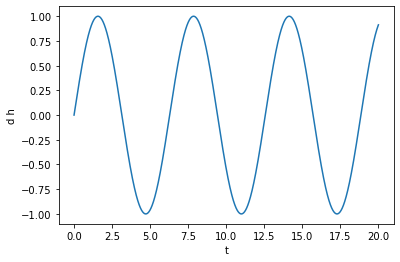

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

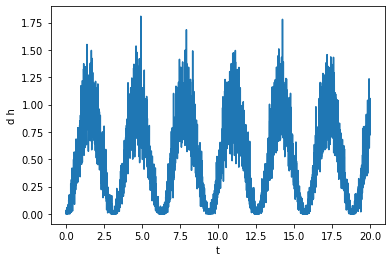

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

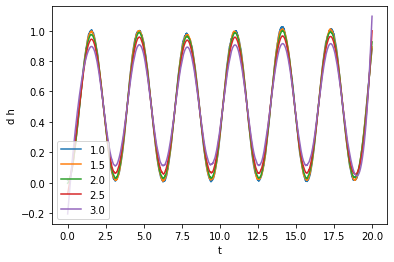

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

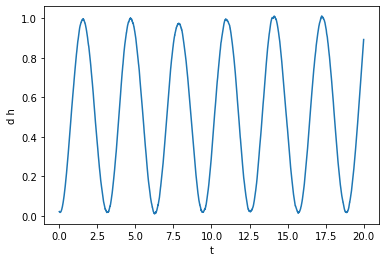

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.1609


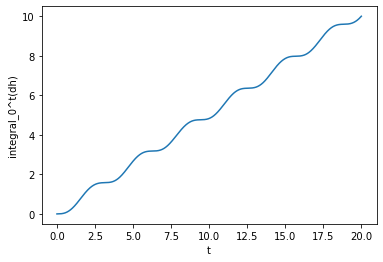

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

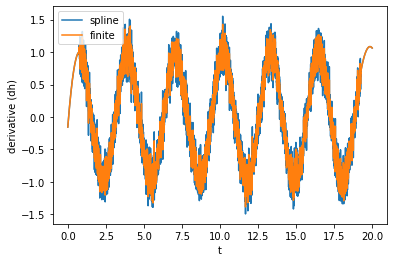

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

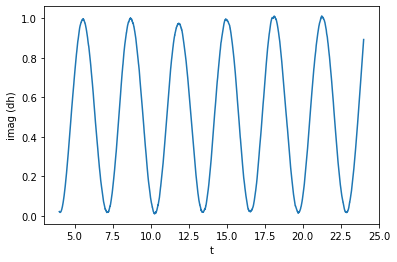

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

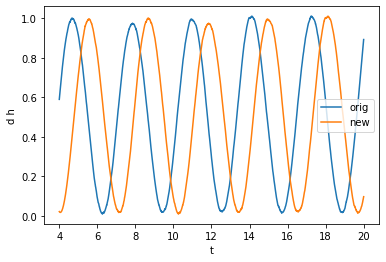

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

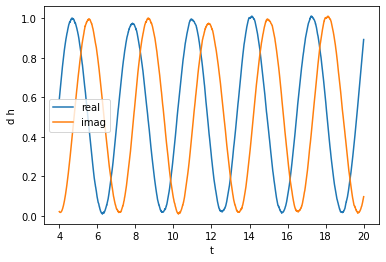

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

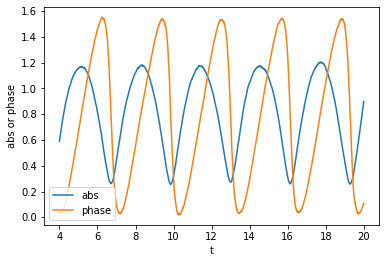

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

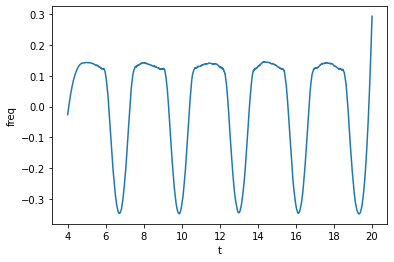

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

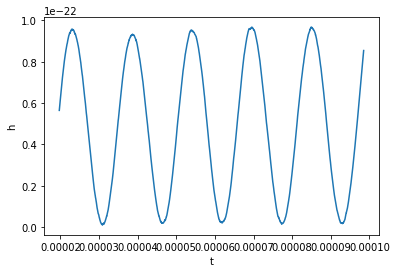

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

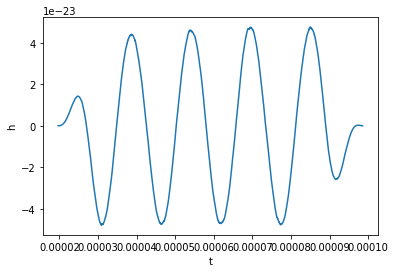

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

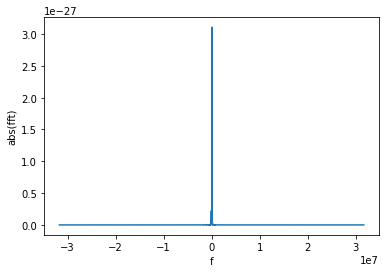

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

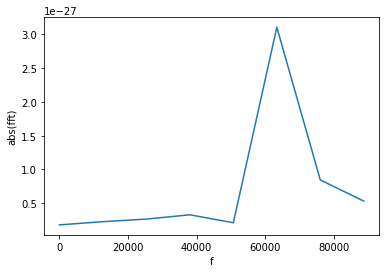

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64211.26


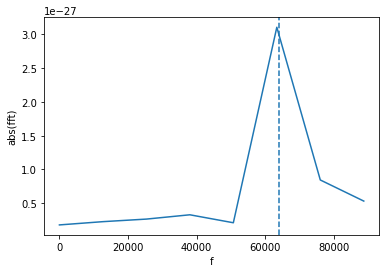

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.107e-27
Maximum with mask 8.443e-28
Length with mask 8
Length after having removed the masked points 7
